# Section 1: Business Understanding

For this project, I was interestested in using **Seattle Airbnb Data from 2016** to better understand:

1. What kind of accommodations do may I book?
2. Which period of the year has the highest number of listings? By how much do prices spike?
3. What are the cheapest and most expensive neighborhoods?
4. What are the factors that most impact the price?

You can find the full set of files related to anaylises in: https://www.kaggle.com/airbnb/seattle/data.

Also, check out my medium post at: https://matsuch.medium.com/can-you-guess-the-best-time-to-visit-seattle-24025ab7da70


In [375]:
#import algebra linear and data manipulation
import numpy as np
import pandas as pd
from collections import defaultdict

#Plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

#Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#opening dataframes
df_review = pd.read_csv('./reviews.csv')
df_listings = pd.read_csv('./listings.csv')
df_calendar = pd.read_csv('./calendar.csv')

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Section 2: Data Undestanding

In [376]:
#==============================================================================
#Spliting dataframes into categories - Host, Review, quarto, bairro
#==============================================================================

host = df_listings[['host_id','host_is_superhost', 'host_response_rate', 'host_response_time']]

review = df_listings[['id','number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

quarto = df_listings[['room_type', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'accommodates','property_type']]

bairro = df_listings[['neighbourhood', 'neighbourhood_cleansed','neighbourhood_group_cleansed']]

In [377]:
#==============================================================
#Data treatment - NaN Values and change object columns in floats
#==============================================================

#host
print('before % of null values : \n', host.isnull().sum()/len(host)*100, '\n') #% NaN values

#transform the host_is_superhost in float
host['host_is_superhost'] = host['host_is_superhost'].map({'f':1,'t':0}) #change f and t for 1 and 0

#Transform the responde_rate column in str and flot to find the mean
host['host_response_rate_num'] = host['host_response_rate'].astype(str)
host['host_response_rate_num'] = host['host_response_rate_num'].str.replace("%", "").astype("float")


#Change responde_time into float and fill with the mean
host['host_response_time'] = host['host_response_time'].map({'within a few hours':6,
                                                           'within an hour':1,
                                                           'within a day':24,
                                                           'a few days or more':48})

#fill host activity by its mean - however its does not seens to effect the dataset
host['host_response_rate_num'] = host['host_response_rate_num'].fillna(host.groupby(['host_id'])
                                                                       ['host_response_rate_num'].transform('mean'))
host['host_response_time'] = host['host_response_time'].fillna(host.groupby(['host_id'])
                                                               ['host_response_time'].transform('mean'))

print('after % of null values : \n', host.isnull().sum()/len(host)*100, '\n') #% NaN values

#Tried to fill the nan with the mean, however since it doesn't I decided to drop all those rows to have a complete dataset
host = host.drop(['host_response_rate'], axis = 1) #drop the old response rate column
hostnew = host.dropna() #drop the remaining nan values, since the new df has 86% of the original size

print('Size comparison between the old and new host df :', len(hostnew)/len(host), '\n')

before % of null values : 
 host_id                0.000000
host_is_superhost      0.052383
host_response_rate    13.698271
host_response_time    13.698271
dtype: float64 

after % of null values : 
 host_id                    0.000000
host_is_superhost          0.052383
host_response_rate        13.698271
host_response_time        13.698271
host_response_rate_num    13.698271
dtype: float64 

Size comparison between the old and new host df : 0.8630172865374541 



In [378]:
'''
OBS: 

I tried to fill nan values with the mean of each id however it does not make sense.
I was looking at the review dataset and noticed that each id is unique
so, I decided to drop all nan values since the new df still has 86% of the original df size
'''

'\nOBS: \n\nI tried to fill nan values with the mean of each id however it does not make sense.\nI was looking at the review dataset and noticed that each id is unique\nso, I decided to drop all nan values since the new df still has 86% of the original df size\n'

In [379]:
#review

#fill all columns with the mean - new approach
'''
review['review_scores_value'] = review.groupby('id')['review_scores_value'].transform(lambda x: x.fillna(x.mean()))
review['review_scores_rating'] = review.groupby('id')['review_scores_rating'].transform(lambda x: x.fillna(x.mean()))
review['review_scores_accuracy'] = review.groupby('id')['review_scores_accuracy'].transform(lambda x: x.fillna(x.mean()))
review['review_scores_cleanliness'] = review.groupby('id')['review_scores_cleanliness'].transform(lambda x: x.fillna(x.mean()))
review['review_scores_checkin'] = review.groupby('id')['review_scores_checkin'].transform(lambda x: x.fillna(x.mean()))
review['review_scores_communication'] = review.groupby('id')['review_scores_communication'].transform(lambda x: x.fillna(x.mean()))
review['review_scores_location'] = review.groupby('id')['review_scores_location'].transform(lambda x: x.fillna(x.mean()))

#NEED TO FIND A FASTER WAY TO PERFORM THIS
'''

print('Sum of nan values per column: \n',review.isnull().sum())
print('number of listings with no reviews: ', (review['number_of_reviews'] == 0).sum())

Sum of nan values per column: 
 id                               0
number_of_reviews                0
review_scores_rating           647
review_scores_accuracy         658
review_scores_cleanliness      653
review_scores_checkin          658
review_scores_communication    651
review_scores_location         655
review_scores_value            656
dtype: int64
number of listings with no reviews:  627


In [380]:
'''
I tried to fill nan values with the mean of each id however it does not make sense.
I was looking at the review dataset and notice that each id is unique, so I decided to drop all nan values
For the propose to anylise the influence in the review score, nan values would have a negative impact on the results

'''

'\nI tried to fill nan values with the mean of each id however it does not make sense.\nI was looking at the review dataset and notice that each id is unique, so I decided to drop all nan values\nFor the propose to anylise the influence in the review score, nan values would have a negative impact on the results\n\n'

In [381]:
#quarto
print(quarto.isnull().sum()) #count null columns
quartonew=quarto.dropna() #drop null values

#bairro
print(quarto.isnull().sum()) #count null columns
bairronew=bairro.dropna() ##drop null values, less than 10% - most of the ananysis here need neighbourhood information


room_type         0
bathrooms        16
bedrooms          6
beds              1
bed_type          0
accommodates      0
property_type     1
dtype: int64
room_type         0
bathrooms        16
bedrooms          6
beds              1
bed_type          0
accommodates      0
property_type     1
dtype: int64


# Section 3: Data Preparation

In [382]:
#===============
#Data treatment
#==============

#creat new df
df_novo = pd.concat((review, quartonew, hostnew, bairronew), axis=1)

#split date information in year and month, drop the original date column
df_calendar['date'] = pd.to_datetime(df_calendar['date'], format= '%Y/%m/%d') #set date in datetime
df_calendar['ano'] = df_calendar['date'].dt.year #create a year column
df_calendar['mês'] = df_calendar['date'].dt.month #create a month column
df_calendar.drop(['date'], axis=1, inplace=True) #drop the old date column

df_novo.rename(index=str, columns={'id': 'listing_id'}, inplace=True) #change the 'id' column name to be the same as the calendar

df = pd.merge(df_calendar, df_novo, on='listing_id') #merge calendar and the new dataframe

df.dropna(subset=['price'],inplace=True) #drop all listings with no price.

df['price'] = df['price'].str.replace("[$, ]", "").astype("float") #replacing $ by "" and converting price column into float

df.head()

,listing_id,available,price,ano,mês,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,bed_type,accommodates,property_type,host_id,host_is_superhost,host_response_time,host_response_rate_num,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,241032,t,85.0,2016,1,207,95.0,10.0,10.0,10.0,...,Real Bed,4.0,Apartment,956883.0,1.0,6.0,96.0,Queen Anne,West Queen Anne,Queen Anne
1,241032,t,85.0,2016,1,207,95.0,10.0,10.0,10.0,...,Real Bed,4.0,Apartment,956883.0,1.0,6.0,96.0,Queen Anne,West Queen Anne,Queen Anne
9,241032,t,85.0,2016,1,207,95.0,10.0,10.0,10.0,...,Real Bed,4.0,Apartment,956883.0,1.0,6.0,96.0,Queen Anne,West Queen Anne,Queen Anne
10,241032,t,85.0,2016,1,207,95.0,10.0,10.0,10.0,...,Real Bed,4.0,Apartment,956883.0,1.0,6.0,96.0,Queen Anne,West Queen Anne,Queen Anne
14,241032,t,85.0,2016,1,207,95.0,10.0,10.0,10.0,...,Real Bed,4.0,Apartment,956883.0,1.0,6.0,96.0,Queen Anne,West Queen Anne,Queen Anne


# Section 4: Modeling

In [383]:
#=====================
#linearization process
#=====================

#turn categorical columns into dummies

cat_col = list(df.select_dtypes(include=['object']).columns)

def create_dummy_df(df, cat_cols, dummy_na):

    for col in cat_cols:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', 
                                                                 drop_first=True, dummy_na=dummy_na)], axis=1)
    return df

#Processo de linearização

#1. Drop the rows with missing response values
df_m = df.dropna(subset=['price'])

#2. Drop columns with Nan for all the values

df_m = df_m.dropna()

#3 Apply dummy_df
df_m = create_dummy_df(df_m,cat_col,dummy_na=True)

#4 Split data into X matriz and response vector y
X = df_m.drop(['price'], axis=1)
y = df_m['price']

#5 Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

#Print training and testing score
print("Training data R²: {:.4f}.  Test data R²: {:.4f}.".format(train_score, test_score))


Training data R²: 0.6782.  Test data R²: 0.6778.


# Section 5: Evaluate the Results

### Question 1: What kind of accommodations may I book?

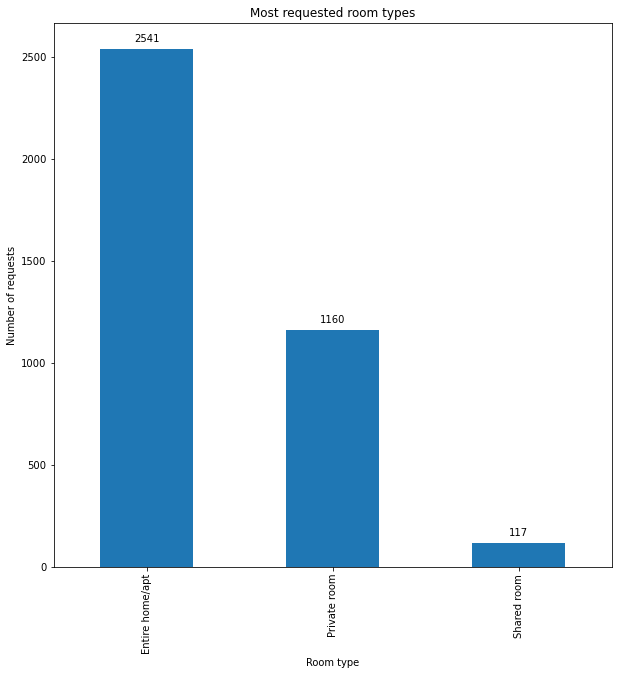

In [384]:
#======================================
#which are the most requested room types
#======================================

#Creating list with the room type counting (there are only 3 types)
room = [df_listings['room_type'].value_counts()[0],
        df_listings['room_type'].value_counts()[1],
        df_listings['room_type'].value_counts()[2]]
room_series = pd.Series(room)

#Unique room types
room_type = df_listings['room_type'].unique().tolist()
room_type_series = pd.Series(room_type)

#plot
plt.figure(figsize=(10,10))
ax = room_series.plot(kind='bar')
ax.set_title('Most requested room types')
ax.set_xlabel('Room type')
ax.set_ylabel('Number of requests')
ax.set_xticklabels(room_type)

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.savefig('Most requested room type.png')

#### These are the most requested room types around Seattle, with more than 50% being "Entire Home/apt"

### Question 2: Which period of the year has the highest number of listings? By how much do prices spike?

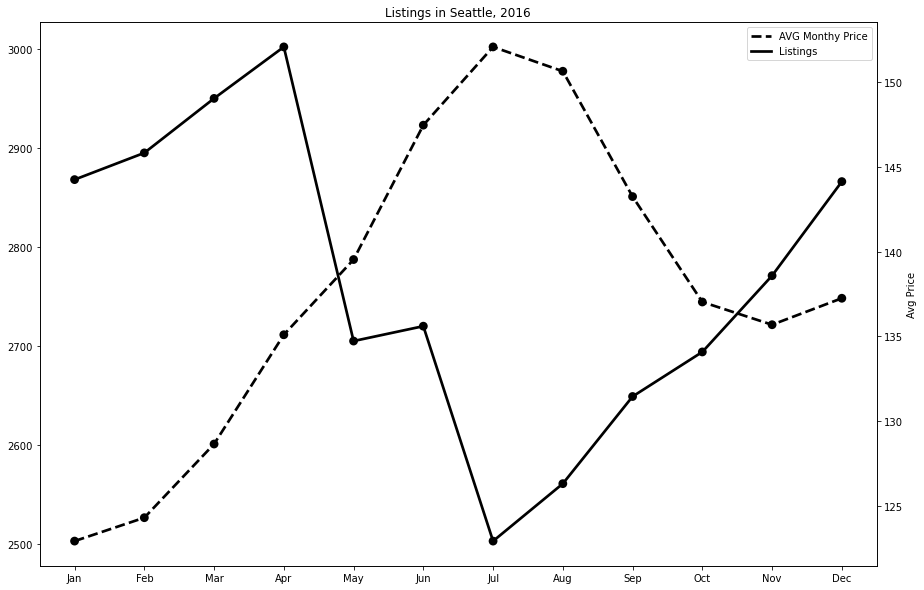

In [385]:
#loop to count how much listings are avaliable per month
hospedagens_mensais = pd.Series([12])
for i in range(1, 13):
    hospedagens_mensais[i] = len(df[(df['mês'] == i) & (df['ano'] == 2016)]['listing_id'].unique()) #count just if the year is 2016

hospedagens_mensais = hospedagens_mensais.drop(0) #drop those listings with no months

meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May' , 'Jun' , 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec']
preco_mensal = df.groupby('mês')['price'].mean() #group by month and mean price

#plot - Pric x Listing - per month
preco_mensal = df.groupby('mês')['price'].mean()
plt.subplots(figsize = (15,10))
ax = plt.gca()
sns.pointplot(x = meses, y = hospedagens_mensais, color='black',linestyles=['-'])
ax2=plt.twinx()
sns.pointplot(x = meses, y = preco_mensal, color='black', linestyles=['--'])
plt.legend(labels=['AVG Monthy Price', 'Listings'])
plt.title('Listings in Seattle, 2016')
plt.ylabel('Avg Price')
plt.xlabel('Months')
plt.savefig('listings x price.png')

#### By the chart above we have that: April is the month with the most number listings and the most expensive time to visit seattle.

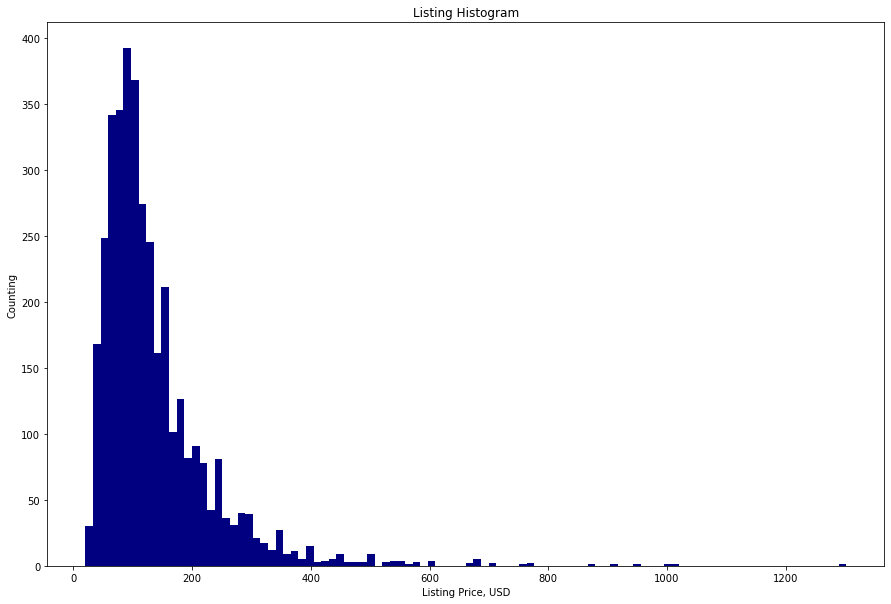

In [386]:
#========================================
#histogram of all listing with mean price
#========================================

df_hist=df.groupby('listing_id')['price'].mean()
plt.figure(figsize=(15,10))
plt.hist(df_hist,bins=100,color='navy')
plt.ylabel('Counting')
plt.xlabel('Listing Price, USD')
plt.title('Listing Histogram')
plt.savefig('Histograma de preços.png')

#### As we can see in the chart below, the avarage price vary between USD 60 to USD 200

### Question 3: What are the cheapest and most expensive neighborhoods?

Expensive neighbourhoods - Highest AVG Price:  $370
Expensive neighbourhoods - Lowest AVG Price:  $226
Avg price:  $264
Price Diff: $144


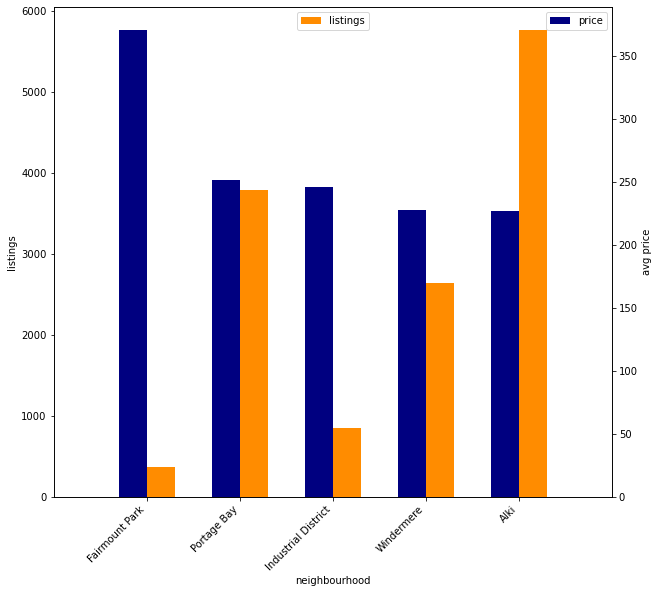

In [387]:
#==========================================================
#Question - which are the monst expensive neighbourhoods?
#==========================================================

preco_bairros = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).reset_index(name='price')

top5_bairros_caros_nome = preco_bairros['neighbourhood'][0:5].tolist()
top5_bairros_caros_preco = preco_bairros['price'][0:5].tolist()   
top5_bairros_caros_qtd = [df.loc[df.neighbourhood == preco_bairros['neighbourhood'][0]  , 'neighbourhood'].count(),
                          df.loc[df.neighbourhood == preco_bairros['neighbourhood'][1]  , 'neighbourhood'].count(),
                          df.loc[df.neighbourhood == preco_bairros['neighbourhood'][2]  , 'neighbourhood'].count(),
                          df.loc[df.neighbourhood == preco_bairros['neighbourhood'][3]  , 'neighbourhood'].count(),
                          df.loc[df.neighbourhood == preco_bairros['neighbourhood'][4]  , 'neighbourhood'].count()]
                         
df_top5 = pd.DataFrame(list(zip(top5_bairros_caros_nome,top5_bairros_caros_qtd,top5_bairros_caros_preco)),columns=['neighbourhood','listings','price'])


df_top5 = df_top5.set_index('neighbourhood')
fig = plt.figure(figsize=(10,10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
width = .3

df_top5.listings.plot(kind='bar',color='darkorange',ax=ax,width=width, position=0,legend=True)
df_top5.price.plot(kind='bar',color='navy', ax=ax2,width = width,position=1,legend=True)

ax.set_ylabel('listings')
ax2.set_ylabel('avg price')
ax.legend(loc='upper center')
fig.autofmt_xdate(rotation=45)

ax.set_xlim(-1,5)
fig.savefig('Top 5 - most expensive neighbourhoods - AVG price x Listing.png')

max_n_price = df_top5['price'].max()
min_n_price = df_top5['price'].min()
mean_n_price = df_top5['price'].mean()
price_diff = max_n_price - min_n_price

print('Expensive neighbourhoods - Highest AVG Price: ',"$%.0f" % max_n_price)
print('Expensive neighbourhoods - Lowest AVG Price: ',"$%.0f" % min_n_price)
print('Avg price: ',"$%.0f" % mean_n_price)
print('Price Diff: '"$%.0f" % price_diff)

Cheapest neighbourhoods - Highest AVG Price:  $78
Cheapest neighbourhoods - Lowest AVG Price:  $60
Avg price:  $72
Price Diff: $18


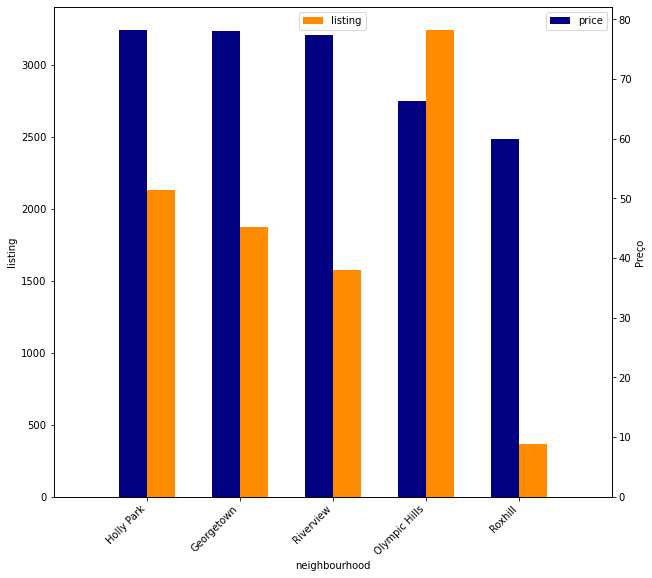

In [388]:
#======================================================
#Question - which are the most cheapest neighbourhoods?
#======================================================

preco_bairros = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).reset_index(name='price')

size = len(preco_bairros.index)

top5_bairros_caros_nome = preco_bairros['neighbourhood'][76:81].tolist()
top5_bairros_caros_preco = preco_bairros['price'][76:81].tolist()   
top5_bairros_caros_qtd = [df.loc[df.neighbourhood == preco_bairros['neighbourhood'][size-5]  , 'neighbourhood'].count(),
                          df.loc[df.neighbourhood == preco_bairros['neighbourhood'][size-4]  , 'neighbourhood'].count(),
                          df.loc[df.neighbourhood == preco_bairros['neighbourhood'][size-3]  , 'neighbourhood'].count(),
                          df.loc[df.neighbourhood == preco_bairros['neighbourhood'][size-2]  , 'neighbourhood'].count(),
                          df.loc[df.neighbourhood == preco_bairros['neighbourhood'][size-1]  , 'neighbourhood'].count()]
                         
df_top5 = pd.DataFrame(list(zip(top5_bairros_caros_nome,top5_bairros_caros_qtd,top5_bairros_caros_preco)),columns=['neighbourhood','listing','price'])


df_top5 = df_top5.set_index('neighbourhood')
fig = plt.figure(figsize=(10,10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
width = .3

df_top5.listing.plot(kind='bar',color='darkorange',ax=ax,width=width, position=0,legend=True)
df_top5.price.plot(kind='bar',color='navy', ax=ax2,width = width,position=1,legend=True)

teste = ['listing','Preço']

ax.set_ylabel('listing')
ax2.set_ylabel('Preço')
ax.legend(loc='upper center')
fig.autofmt_xdate(rotation=45)

ax.set_xlim(-1,5)
fig.savefig('Top 5 - Bairros mais baratos - Preço x Disponibilidade.png')

max_n_price = df_top5['price'].max()
min_n_price = df_top5['price'].min()
mean_n_price = df_top5['price'].mean()
price_diff = max_n_price - min_n_price

print('Cheapest neighbourhoods - Highest AVG Price: ',"$%.0f" % max_n_price)
print('Cheapest neighbourhoods - Lowest AVG Price: ',"$%.0f" % min_n_price)
print('Avg price: ',"$%.0f" % mean_n_price)
print('Price Diff: '"$%.0f" % price_diff)

#### Prabably most of the biggest places in seattle are located in the "Most Expensive Neighbourhood" chart and that the smallest places are in the "Cheapest neighbourhood" chart

### Question 4: What are the factors that most impact the price?

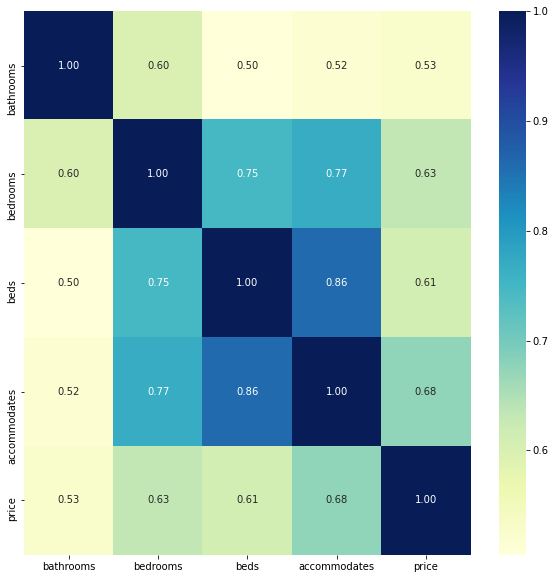

In [389]:
#Heatmap area
df2 = df.copy()
df_fisico = df2[['bathrooms', 'bedrooms', 'beds', 'accommodates','price']]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_fisico.corr(), annot=True, fmt='.2f',ax=ax, cmap="YlGnBu")
plt.savefig('Heatmap - Space.png')

#### The chart above behave as exepcted: With more bathrooms, bedrooms, bed the bigger will be the place and higher will be the price. 
#### Accommodates showns to be the most infleunce in the price.

## SUPPORT CHARTS AND OTHERS QUESTIONS

In [390]:
def contagem_total(df, col1, col2, procura):

    '''
        INPUT:
            df - Dataframe that you are looking for
            col1 - column that you go through
            col2 - column with the values that you want
            procura - list containing the data you are looking for in each line of the df[col]

        OUTPUT:
            new_df - the new dataframe that has the unique counting

    '''

    new_df = defaultdict(int)
    
    #Loop in the list you want search for
    for val in procura:
        #Loop
        for x in range(df.shape[0]):
            #if found what you want, add 1
            if val in df[col1][x]:
                new_df[val] += int(df[col2][x])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    return new_df

In [391]:
amenities = ["TV","Internet","Wireless Internet","Cable TV","Air Conditioning","Kitchen",
             "Elevator in Building","Wheelchair Accessible","Smoke Detector","Free Parking on Premises","Pool",
             "Pets live on this property","Breakfast","Gym","Heating","Washer","Buzzer/Wireless Intercom","Smoking Allowed",
             "Carbon Monoxide Detector","Pets Allowed","Indoor Fireplace","Dryer","Dog(s)","Family/Kid Friendly","Hot Tub",
             "Cat(s)","Essentials","Shampoo","First Aid Kit","Doorman","Fire Extinguisher","Safety Card","Washer / Dryer",
             "Suitable for Events","Other pet(s)","Hangers","24-Hour Check-in","Laptop Friendly Workspace",
             "Lock on Bedroom Door","Hair Dryer","Iron"]

#Create new_df based on 'amenities' unique couting
df_amen = df_listings['amenities'].value_counts().reset_index()
df_amen.rename(columns={'index': 'Count'}, inplace=True)

new_df = contagem_total(df_amen,'Count','amenities',amenities)
new_df.set_index('Count',inplace=True)  

<AxesSubplot:xlabel='Count'>

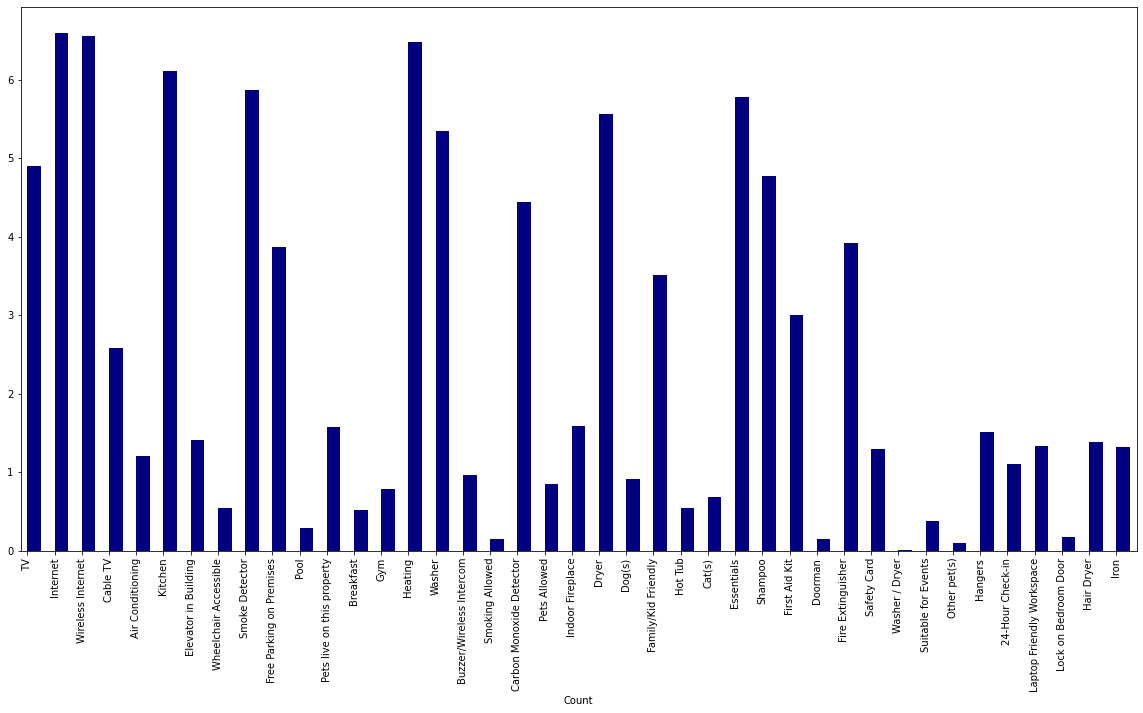

In [392]:
#===========
#aminities %
#===========

perc = (new_df/new_df.sum()*100)
fig = plt.figure(figsize=(20,10)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = .5

perc.plot(kind='bar',color='navy',width=width,ax=ax, position=0,legend=False)

#### This chart showns what it's the % of listings that have each amentities. internet, kitchen, smoke dectetor, heating, dryer, essetials are the most common amentities in Seattle.

In [393]:
#================================================
#Question - How does the price vary in Seattle?
#================================================

max_n_price = df['price'].max()
min_n_price = df['price'].min()
mean_n_price = df['price'].mean()

print('Highest Price: ',"$%.0f" % max_n_price)
print('Lowest Price: ',"$%.0f" % min_n_price)
print('Avg price: ',"$%.0f" % mean_n_price)

Highest Price:  $1650
Lowest Price:  $10
Avg price:  $138


,guests,accommodates,percentage
0,2.0,401579.0,43.30
1,4.0,188464.0,20.32
2,3.0,88632.0,9.56
3,6.0,81943.0,8.84
4,1.0,68983.0,7.44


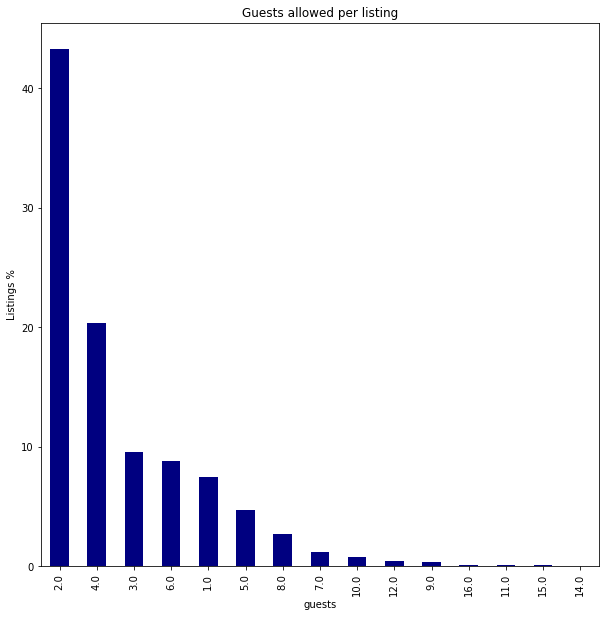

In [394]:
#===============================================
#How many guests are allowed in thoses listings?
#===============================================

df_acco = df['accommodates'].value_counts().reset_index().astype("float")
df_acco.rename(columns={'index': 'guests'}, inplace=True)
df_acco.set_index('guests')

def compute_percentage(x):
    pct = x/df_acco['accommodates'].sum()*100
    return round(pct, 2)

df_acco['percentage'] = df_acco['accommodates'].apply(compute_percentage)

fig = plt.figure(figsize=(10,10)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
plt.ylabel('Listings %')
plt.xlabel('Number of Guests allowed')
plt.title('Guests allowed per listing')
width = .5

df_acco.plot(kind='bar',x='guests',y='percentage',color='navy',width=width,ax=ax,legend=False)
plt.savefig('Accommodates per listing')
df_acco.head()

#### Above we can see that more than 40% of the listings allow just 2 guests

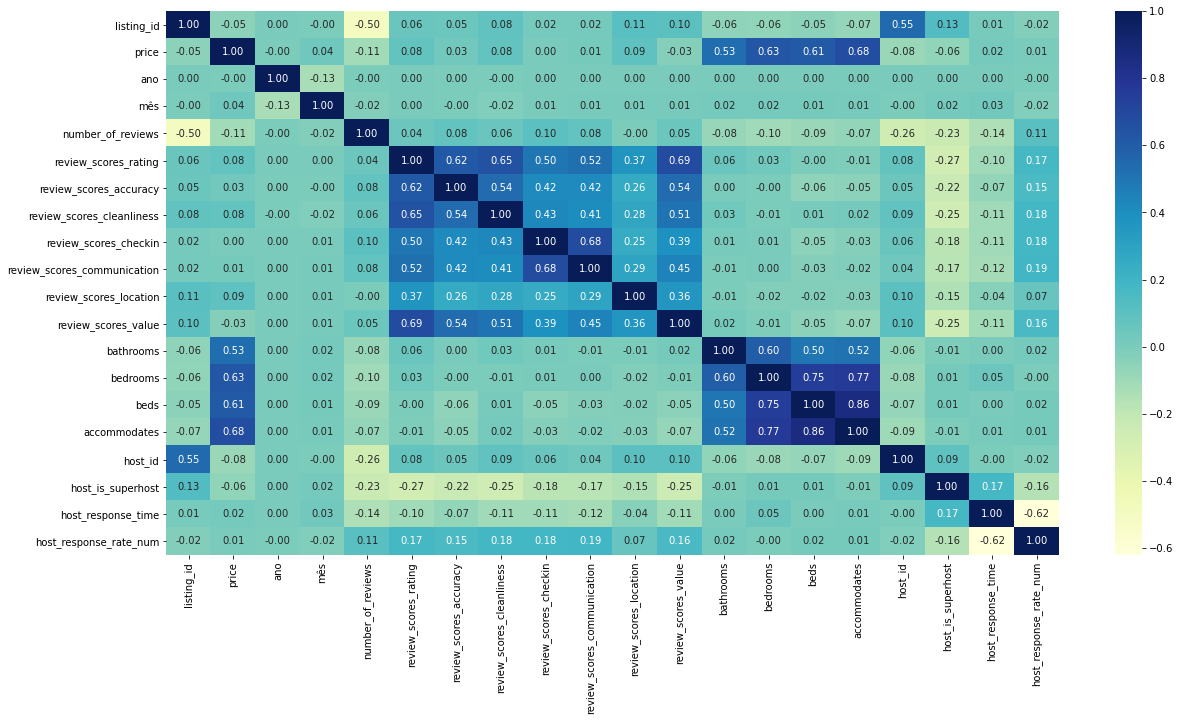

In [395]:
#heatmap
df_hc = df.select_dtypes(include=['float','int64']).copy()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_hc.corr(), annot=True, fmt='.2f',ax=ax, cmap="YlGnBu")
plt.savefig('Heatmap - Geral.png')

#### The chart above we have a overall heatmap, I did it to see how those informations impact price and review after that I decided to split into small charts since price its more related to bathrooms, bedrooms, beds and accommodates


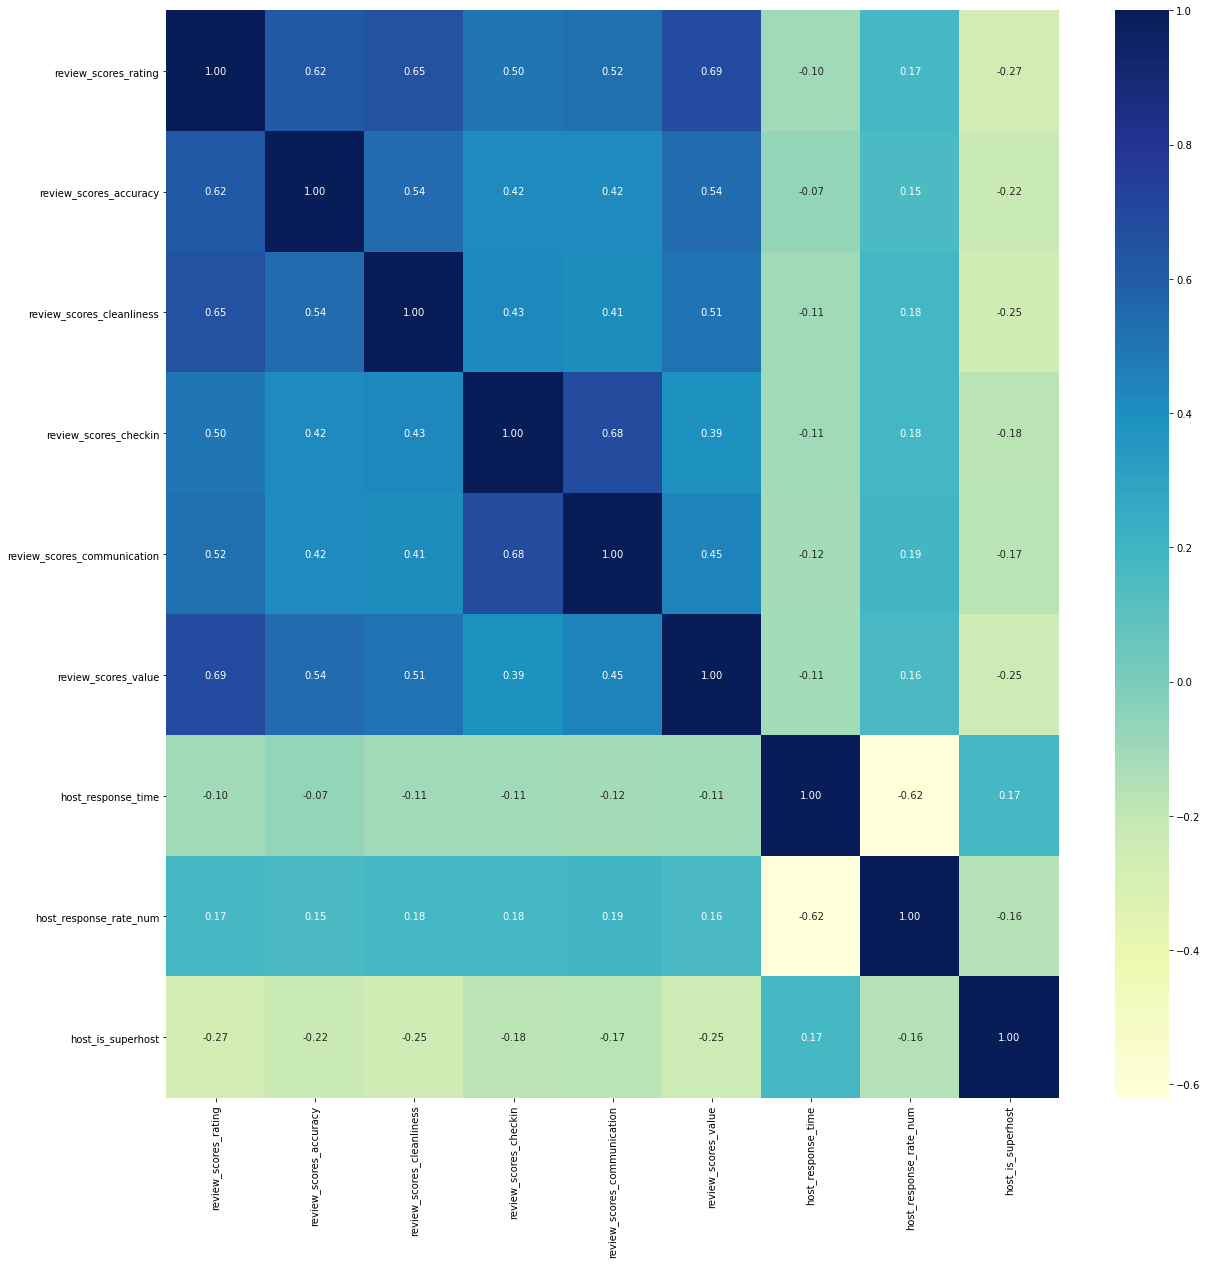

In [396]:
#Review and host heatmap
df_review = df2[['review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin',
                 'review_scores_communication','review_scores_value', 'host_response_time', 'host_response_rate_num' ,
                 'host_is_superhost']]
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_review.corr(), annot=True, fmt='.2f',ax=ax, cmap="YlGnBu")
plt.savefig('Heatmap - Review.png')

#### The fact that the host is a super host, slightly affects its response time. Here I was trying to identify if the host activity had some positive influence in the review_score_value, however it didnt seens to be a problem